## Load Model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
#import tensorflow.keras as tfk
#from tensorflow import keras as tfk
from astroNN.models import ApogeeCNN, ApogeeBCNN
from astroNN.datasets import H5Loader
from astroNN.nn.losses import mean_squared_error, mean_absolute_error, mean_error
import matplotlib.pyplot as plt

/anaconda3/envs/tf.1.4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/tf.1.4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/tf.1.4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/tf.1.4/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
# import everything we need
from astroNN.models import load_folder
# load the pretrained base CNN and BCNN model
tf.reset_default_graph()

Bnet = load_folder("astroNN_spectra_paper_figures/astroNN_0606_run001")

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNN


In [3]:
Bnet.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 7514, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 7514, 2)      18          input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 7514, 2)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
MCDropout_1 (MCDropout)         (None, 7514, 2)      0           activation_1[0][0]               
__________________________________________________________________________________________________
conv1d_2 (

In [4]:
# create a BCNN instance and then assign pretrained weights
import numpy as np
import tensorflow as tf
from astroNN.config import keras_import_manager
tfk = keras_import_manager()
from astroNN.apogee import aspcap_mask
from astroNN.apogee.plotting import ASPCAP_plots
from astroNN.models.base_bayesian_cnn import BayesianCNNBase
from astroNN.models.base_cnn import CNNBase
from astroNN.models.base_vae import ConvVAEBase
from astroNN.nn.layers import MCDropout, BoolMask, StopGrad, KLDivergenceLayer
from astroNN.nn.losses import bayesian_binary_crossentropy_wrapper, bayesian_binary_crossentropy_var_wrapper
from astroNN.nn.losses import bayesian_categorical_crossentropy_wrapper, bayesian_categorical_crossentropy_var_wrapper
from astroNN.nn.losses import mse_lin_wrapper, mse_var_wrapper

Add = tfk.layers.Add
Dense = tfk.layers.Dense
Input = tfk.layers.Input
Conv1D = tfk.layers.Conv1D
Lambda = tfk.layers.Lambda
Reshape = tfk.layers.Reshape
Dropout = tfk.layers.Dropout
Flatten = tfk.layers.Flatten
Multiply = tfk.layers.Multiply
Activation = tfk.layers.Activation
concatenate = tfk.layers.concatenate
MaxPooling1D = tfk.layers.MaxPooling1D

Model = tfk.models.Model
Sequential = tfk.models.Sequential

regularizers = tfk.regularizers
MaxNorm = tfk.constraints.MaxNorm
RandomNormal = tfk.initializers.RandomNormal


class ApogeeBCNN(BayesianCNNBase, ASPCAP_plots):
    """
    Class for Bayesian convolutional neural network for stellar spectra analysis

    :History: 2017-Dec-21 - Written - Henry Leung (University of Toronto)
    """

    def __init__(self, lr=0.0005, dropout_rate=0.3):
        super().__init__()

        self._implementation_version = '1.0'
        self.initializer = RandomNormal(mean=0.0, stddev=0.05)
        self.activation = 'relu'
        self.num_filters = [2, 4]
        self.filter_len = 8
        self.pool_length = 4
        self.num_hidden = [256, 128] #based on paper
        self.max_epochs = 100
        self.lr = 0.0005
        self.reduce_lr_epsilon = 0.00005

        self.reduce_lr_min = 1e-8
        self.reduce_lr_patience = 2
        self.l2 = 5e-9
        self.dropout_rate = 0.3

        self.input_norm_mode = 3

        self.task = 'regression'

        self.targetname = ['teff', 'logg', 'C', 'C1', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'K',
                  'Ca', 'Ti', 'Ti2', 'V', 'Cr', 'Mn', 'Fe','Co', 'Ni']
    def model(self):
        input_tensor = Input(shape=self._input_shape, name='input')
        labels_err_tensor = Input(shape=(self._labels_shape,), name='labels_err')

        cnn_layer_1 = Conv1D(kernel_initializer=self.initializer, padding="same", filters=self.num_filters[0],
                             kernel_size=self.filter_len, kernel_regularizer=regularizers.l2(self.l2))(input_tensor)
        activation_1 = Activation(activation=self.activation)(cnn_layer_1)
        dropout_1 = MCDropout(self.dropout_rate, disable=self.disable_dropout)(activation_1)
        cnn_layer_2 = Conv1D(kernel_initializer=self.initializer, padding="same", filters=self.num_filters[1],
                             kernel_size=self.filter_len, kernel_regularizer=regularizers.l2(self.l2))(dropout_1)
        activation_2 = Activation(activation=self.activation)(cnn_layer_2)
        maxpool_1 = MaxPooling1D(pool_size=self.pool_length)(activation_2)
        flattener = Flatten()(maxpool_1)
        dropout_2 = MCDropout(self.dropout_rate, disable=self.disable_dropout)(flattener)
        layer_3 = Dense(units=self.num_hidden[0], kernel_regularizer=regularizers.l2(self.l2),
                        kernel_initializer=self.initializer)(dropout_2)
        activation_3 = Activation(activation=self.activation)(layer_3)
        dropout_3 = MCDropout(self.dropout_rate, disable=self.disable_dropout)(activation_3)
        layer_4 = Dense(units=self.num_hidden[1], kernel_regularizer=regularizers.l2(self.l2),
                        kernel_initializer=self.initializer)(dropout_3)
        activation_4 = Activation(activation=self.activation)(layer_4)
        output = Dense(units=self._labels_shape, activation=self._last_layer_activation, name='output')(activation_4)
        variance_output = Dense(units=self._labels_shape, activation='linear', name='variance_output')(activation_4)

        model = Model(inputs=[input_tensor, labels_err_tensor], outputs=[output, variance_output])
        # new astroNN high performance dropout variational inference on GPU expects single output
        model_prediction = Model(inputs=[input_tensor], outputs=concatenate([output, variance_output]))

        if self.task == 'regression':
            variance_loss = mse_var_wrapper(output, labels_err_tensor)
            output_loss = mse_lin_wrapper(variance_output, labels_err_tensor)
        elif self.task == 'classification':
            output_loss = bayesian_categorical_crossentropy_wrapper(variance_output)
            variance_loss = bayesian_categorical_crossentropy_var_wrapper(output)
        elif self.task == 'binary_classification':
            output_loss = bayesian_binary_crossentropy_wrapper(variance_output)
            variance_loss = bayesian_binary_crossentropy_var_wrapper(output)
        else:
            raise RuntimeError('Only "regression", "classification" and "binary_classification" are supported')

        return model, model_prediction, output_loss, variance_loss


In [5]:
import numpy as np

from astroNN.datasets import H5Loader
from astroNN.apogee import aspcap_mask
from astroNN.models import ApogeeBCNNCensored

# Load the training data
loader = H5Loader('/Users/nhuang37/Desktop/NYU DS/Yr 2 Sem1/Capstone/AstroNN/astroNN_spectra_paper_figures/__train_r_giant_1k_8575_1125_1557.h5')
loader.load_err = True
loader.target = ['teff', 'logg', 'C', 'C1', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'K',
                  'Ca', 'Ti', 'Ti2', 'V', 'Cr', 'Mn', 'Fe','Co', 'Ni']
x,y,x_err,y_err = loader.load()

/anaconda3/envs/tf.1.4/lib/python3.6/site-packages/astroNN/datasets/h5.py:581: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.h5path) as F:  # ensure the file will be cleaned up
/anaconda3/envs/tf.1.4/lib/python3.6/site-packages/astroNN/datasets/h5.py:613: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.h5path) as F:  # ensure the file will be cle

In [6]:
from astroNN.apogee import visit_spectra, combined_spectra, gap_delete, apogee_continuum, bitmask_boolean
x = gap_delete(x, dr=14)
x_err = gap_delete(x_err, dr=14)
x.shape

(1000, 7514)

In [7]:
##create the same model instance as pretrained in tf2.0 and thenload weight in tf14
final_model = ApogeeBCNN()
final_model.max_epochs = 1
#compile the model by calling train (error after 1 epoch)
final_model.train(x,y,labels_err=y_err)

Number of Training Data: 900, Number of Validation Data: 100
====Message from Normalizer====
You selected mode: 3
Featurewise Center: True
Datawise Center: False
Featurewise std Center: False
Datawise std Center: False
====Message ends====
====Message from Normalizer====
You selected mode: 2
Featurewise Center: True
Datawise Center: False
Featurewise std Center: True
Datawise std Center: False
====Message ends====
Epoch 1/1
 - 3s - loss: 0.4703 - output_loss: 0.4703 - variance_output_loss: 0.4703 - output_mean_absolute_error: 0.7591 - output_mean_error: 0.0328 - val_loss: 0.5422 - val_output_loss: 0.5421 - val_variance_output_loss: 0.5421 - val_output_mean_absolute_error: 0.8882 - val_output_mean_error: 0.1890
Completed Training, 4.03s in total


In [8]:
for layer in final_model.keras_model.layers:
    g=layer.get_config()
    weights = layer.get_weights()
    print (g)
    print(weights)

{'batch_input_shape': (None, 7514, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input'}
[]
{'name': 'conv1d_3', 'trainable': True, 'filters': 2, 'kernel_size': (8,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1,), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 4.999999969612645e-09}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[[ 0.04333283,  0.03383639]],

       [[ 0.0472983 ,  0.05501537]],

       [[ 0.03532702, -0.01804375]],

       [[ 0.02769657,  0.0480402 ]],

       [[-0.00287624,  0.01882867]],

       [[ 0.01864398,  0.04574974]],

       [[ 0.02671286,  0.11213937]],

       [[ 0.01894389,  0.07149903]]], dtype=float32), a

{'name': 'output', 'trainable': True, 'units': 22, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[-0.11880396, -0.11561037, -0.0289393 , ...,  0.06409696,
        -0.14938883,  0.05330218],
       [ 0.05431642,  0.01636878, -0.12251635, ..., -0.06313293,
        -0.09521788,  0.17080542],
       [ 0.07752582,  0.00140598, -0.0801395 , ...,  0.19096859,
         0.10780892, -0.03452501],
       ...,
       [ 0.02360013,  0.15976058,  0.1766308 , ...,  0.12501468,
        -0.17605324, -0.03709472],
       [ 0.13186447, -0.10610107, -0.17098875, ...,  0.12201861,
         0.12720679,  0.14256087],
       [ 0.07897446,  0.12497589, -0.19367395, ..., -0.0

In [9]:
#load the pretrained accurate weights into final_model.model
final_model.keras_model.load_weights('astroNN_spectra_paper_figures/astroNN_0606_run001/model_weights.h5')

In [10]:
for layer in final_model.keras_model.layers:
    g=layer.get_config()
    weights = layer.get_weights()
    print (g)
    print(weights)

{'batch_input_shape': (None, 7514, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input'}
[]
{'name': 'conv1d_3', 'trainable': True, 'filters': 2, 'kernel_size': (8,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1,), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 4.999999969612645e-09}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[[-0.09652549, -0.2489283 ]],

       [[ 0.01814175, -0.18375222]],

       [[ 0.14887606, -0.18402125]],

       [[ 0.1334438 , -0.27137133]],

       [[ 0.23086593, -0.1801472 ]],

       [[ 0.18287252, -0.01084171]],

       [[ 0.2220627 ,  0.01960662]],

       [[ 0.2190144 ,  0.33213758]]], dtype=float32), a

In [11]:
print(final_model.keras_model.inputs)
print(final_model.keras_model.outputs)

[<tf.Tensor 'input_1:0' shape=(?, 7514, 1) dtype=float32>, <tf.Tensor 'labels_err_1:0' shape=(?, 22) dtype=float32>]
[<tf.Tensor 'output_1/BiasAdd:0' shape=(?, 22) dtype=float32>, <tf.Tensor 'variance_output_1/BiasAdd:0' shape=(?, 22) dtype=float32>]


## Load attacked input

In [12]:
#a = np.around(np.linspace(0.1, 1, num=10),decimals=1)
size = np.concatenate((np.around(np.linspace(0.001, 0.01, num=10),decimals=3), 
                      np.around(np.linspace(0.02, 0.1, num=9),decimals=2)))
size = size[:11]
size

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.02 ])

In [14]:
import pickle
with open('rerun_1k_MSE/attack_dict_fgsm_scaled_tar.pkl', 'rb') as f:
    fgsm_dict = pickle.load(f)
fgsm_dict.keys()

dict_keys([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02])

In [15]:
with open('rerun_1k_new/attack_dict_fgsm_tar.pkl', 'rb') as f:
    fgsm_dict_r = pickle.load(f)
fgsm_dict_r.keys()

dict_keys([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02])

## Evaluate attacks

In [18]:
# decrease the number of MCMC in variation inference to get prelim results
final_model.mc_num = 20

In [21]:
# Predictions for FGSM attacked input
pred_bad_fgsm, predi_bad_std_fgsm = [],[]
for key, value in fgsm_dict.items():
    y_predi_bad,y_predi_bad_std  = final_model.test(value)
    pred_bad_fgsm.append(y_predi_bad)
    predi_bad_std_fgsm.append(y_predi_bad_std )

Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 21.74s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 23.88s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 26.33s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 21.09s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 21.13s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 23.51s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 22.20s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 21.59s elapsed
Starting Dropout Variational Inference
Completed Dropout

In [22]:
#save bad pred, normal pred to pickles
save_dict = {'pred_bad':pred_bad_fgsm, 'pred_bad_std':predi_bad_std_fgsm}
with open('rerun_1k_MSE/adv_preds_fgsm_tar.pkl', 'wb') as f:
    pickle.dump(save_dict, f)

In [23]:
# Prediction for random perturbed inputs
pred_bad_fgsm_r, predi_bad_std_fgsm_r = [],[]
for key, value in fgsm_dict_r.items():
    y_predi_bad,y_predi_bad_std  = final_model.test(value)
    pred_bad_fgsm_r.append(y_predi_bad)
    predi_bad_std_fgsm_r.append(y_predi_bad_std )

Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 20.63s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 20.42s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 24.45s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 22.47s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 22.65s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 22.63s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 22.26s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 23.28s elapsed
Starting Dropout Variational Inference
Completed Dropout

In [24]:
#save bad pred, normal pred to pickles
save_dict = {'pred_bad':pred_bad_fgsm_r, 'pred_bad_std':predi_bad_std_fgsm_r}
with open('rerun_1k_new/adv_preds_fgsm_robust_tar.pkl', 'wb') as f:
    pickle.dump(save_dict, f)

In [25]:
#load saved adv attack preds with MSE loss
with open('rerun_1k_MSE/adv_preds_fgsm_tar.pkl', 'rb') as f:
    adv_pred_fgsm = pickle.load(f)

In [26]:
#load saved adv attack preds_random
with open('rerun_1k_new/adv_preds_random.pkl', 'rb') as f:
    adv_random = pickle.load(f)

In [27]:
#load saved adv attack preds with Robust loss
with open('rerun_1k_new/adv_preds_fgsm_robust_tar.pkl', 'rb') as f:
    adv_pred_fgsm_r = pickle.load(f)

In [28]:
adv_random.keys()

dict_keys(['y_predi', 'y_predi_std', 'pred_bad', 'pred_bad_std'])

In [29]:
#function to calculate rmse
def getrmse(y_pred,y_true):
    return(np.sqrt(np.mean((y_pred - y_true)**2)))

In [30]:
#get result of normal pred
y_predi, y_predi_std = adv_random['y_predi'],adv_random['y_predi_std']
#normal pred rmse
mse_norm = getrmse(y_predi[:,[0,1,19]],y[:,[0,1,19]])
#mean of prediction std
col_idx = np.array([0,1,19])
mean_var = np.mean(y_predi_std ['total'][:,col_idx],axis=0)
mean_var_model= np.mean(y_predi_std ['model'][:,col_idx],axis=0)
mean_var_pred = np.mean(y_predi_std ['predictive'][:,col_idx],axis=0)

In [31]:
y_predi.shape

(1000, 22)

### Rescale functions for MSE plot (to be compared with Linear & Cannon models)

In [128]:
# make a copy y
from copy import deepcopy
#label_vals = deepcopy(y_predi)
label_vals = deepcopy(y)
# remove outliters and map data to [-1,1]
def scale_dataset(label_vals):
    ## scale
    scales = {}
    
    # bottom 2.5%
    two5 = np.percentile(label_vals,2.5,axis=0)
    outlier_list_lower = np.where(label_vals < two5)
    # above 97.5%
    nine75 = np.percentile(label_vals,97.5,axis=0)
    outlier_list_upper = np.where(label_vals > nine75)

    # save for rescaling
    scales['two5'] = two5
    scales['nine75'] = nine75
    
    # replace above 97.5% with 97.5%
    for idx,col in zip(outlier_list_upper[0],outlier_list_upper[1]):
        label_vals[idx,col] = nine75[col]
    # replace below 2.5% with 2.5%
    for idx,col in zip(outlier_list_lower[0],outlier_list_lower[1]):
        label_vals[idx,col] = two5[col]
        
    # transform to {-1,1}
    for i in range(label_vals.shape[1]):
        label_vals[:,i] = np.interp(label_vals[:,i], (label_vals[:,i].min(), label_vals[:,i].max()), (-1, +1))

    return label_vals, scales

def rescale_dataset(label_vals,scales):
    lvec_rescale = np.zeros((label_vals.shape[0],3))
    label_vals = label_vals[:,1:4]
    for i in range(lvec_rescale.shape[1]):
        lvec_rescale[:,i] = np.interp(label_vals[:,i], (label_vals[:,i].min(), label_vals[:,i].max()),\
                                    (scales['two5'][i], scales['nine75'][i]))
    return lvec_rescale

In [130]:
#get scales
label_vals, scales = scale_dataset(label_vals[:,[0,1,19]])
#updated scale   
b_teff = 1 - (2*scales['nine75'][0])/(scales['nine75'][0]-scales['two5'][0])
A_teff = 2/(scales['nine75'][0]-scales['two5'][0])
b_g = 1 - (2*scales['nine75'][1])/(scales['nine75'][1]-scales['two5'][1])
A_g = 2/(scales['nine75'][1]-scales['two5'][1])
b_ab = 1 - (2*scales['nine75'][2])/(scales['nine75'][2]-scales['two5'][2])
A_ab = 2/(scales['nine75'][2]-scales['two5'][2])
A = np.hstack((A_teff,A_g,A_ab))
b = np.hstack((b_teff,b_g,b_ab))
    
def scale_predictions(predicted_labels, scales=scales, A=A, b=b):

    label_vals = np.zeros(predicted_labels.shape)
    
    # transform to {-1,1}
    for i in range(predicted_labels.shape[1]):
        label_vals[:,i] = A[i]*predicted_labels[:,i] + b[i]
    return label_vals

In [133]:
#get scaled pred for MSE & Dist
y_random_scaled = scale_predictions(adv_random['pred_bad'][0][:,[0,1,19]])

In [134]:
y_random_scaled.max(), y_random_scaled.min()

(1.3903543949127197, -1.4738566875457764)

In [135]:
#helper function to plot re-scaled MSE
def plot_MSE_scale(adv_random, adv_pred_fgsm, adv_pred_pgd,y):
    #adv rmse _ random perturb _ size 0.001 - 0.1
    mse_norm = getrmse(scale_predictions(y_predi[:,[0,1,19]]),scale_predictions(y[:,[0,1,19]]))
    rmse_pred_bad_r,rmse_pred_bad_pgd, rmse_pred_bad_fgsm, = [],[],[]
    col_idx = np.array([0,1,19])
    for i in range(len(size)):
        rmse_pred_bad_r.append(getrmse(scale_predictions(adv_random['pred_bad'][i][:,[0,1,19]]),scale_predictions(y[:,[0,1,19]])))
        rmse_pred_bad_fgsm.append(getrmse(scale_predictions(adv_pred_fgsm['pred_bad'][i][:,[0,1,19]]),scale_predictions(y[:,[0,1,19]])))
        rmse_pred_bad_pgd.append(getrmse(scale_predictions(adv_pred_pgd['pred_bad'][i][:,[0,1,19]]),scale_predictions(y[:,[0,1,19]])))

    return mse_norm, rmse_pred_bad_r, rmse_pred_bad_fgsm, rmse_pred_bad_pgd 

### Calculate MSE and other metrics in  original scale

In [136]:
size = np.concatenate((np.around(np.linspace(0.001, 0.01, num=10),decimals=3), 
                      np.around(np.linspace(0.02, 0.1, num=9),decimals=2)))
size=size[:11]
size

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.02 ])

In [137]:
#adv rmse: random perturb 
rmse_pred_bad_r, mean_var_bad_total_r,mean_var_bad_model_r,mean_var_bad_pred_r = [],[],[],[]
col_idx = np.array([0,1,19])
for i in range(len(size)):
    rmse_pred_bad_r.append(getrmse(adv_random['pred_bad'][i][:,[0,1,19]],y_predi[:,[0,1,19]]))
    mean_var_bad_total_r.append(np.mean(adv_random['pred_bad_std'][i]['total'][:,col_idx],axis=0))
    mean_var_bad_model_r.append(np.mean(adv_random['pred_bad_std'][i]['model'][:,col_idx],axis=0))
    mean_var_bad_pred_r.append(np.mean(adv_random['pred_bad_std'][i]['predictive'][:,col_idx],axis=0))

In [138]:
#adv rmse adv : fgsm with MSE loss
rmse_pred_bad_fgsm, mean_var_bad_total_fgsm,mean_var_bad_model_fgsm,mean_var_bad_pred_fgsm = [],[],[],[]
col_idx = np.array([0,1,19])
for i in range(len(size)):
    rmse_pred_bad_fgsm.append(getrmse(adv_pred_fgsm['pred_bad'][i][:,[0,1,19]],y_predi[:,[0,1,19]]))
    mean_var_bad_total_fgsm.append(np.mean(adv_pred_fgsm['pred_bad_std'][i]['total'][:,col_idx],axis=0))
    mean_var_bad_model_fgsm.append(np.mean(adv_pred_fgsm['pred_bad_std'][i]['model'][:,col_idx],axis=0))
    mean_var_bad_pred_fgsm.append(np.mean(adv_pred_fgsm['pred_bad_std'][i]['predictive'][:,col_idx],axis=0))

In [139]:
#adv rmse adv : fgsm with robust loss
rmse_pred_bad_fgsm_r, mean_var_bad_total_fgsm_r,mean_var_bad_model_fgsm_r,mean_var_bad_pred_fgsm_r = [],[],[],[]
col_idx = np.array([0,1,19])
for i in range(len(size)):
    rmse_pred_bad_fgsm_r.append(getrmse(adv_pred_fgsm_r['pred_bad'][i][:,[0,1,19]],y_predi[:,[0,1,19]]))
    mean_var_bad_total_fgsm_r.append(np.mean(adv_pred_fgsm_r['pred_bad_std'][i]['total'][:,col_idx],axis=0))
    mean_var_bad_model_fgsm_r.append(np.mean(adv_pred_fgsm_r['pred_bad_std'][i]['model'][:,col_idx],axis=0))
    mean_var_bad_pred_fgsm_r.append(np.mean(adv_pred_fgsm_r['pred_bad_std'][i]['predictive'][:,col_idx],axis=0))

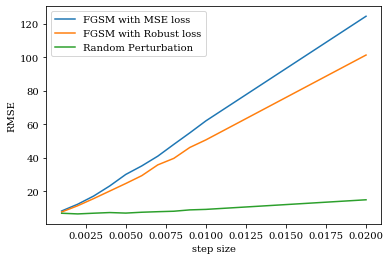

In [142]:
#plot MSE w.r.t step size (add more larger step: 0.1-1)
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':10})
#plt.plot(size, rmse_pred_bad_pgd,label='PGD') 
plt.plot(size[:11], rmse_pred_bad_fgsm[:11],label='FGSM with MSE loss')
plt.plot(size[:11], rmse_pred_bad_fgsm_r[:11],label='FGSM with Robust loss')
plt.plot(size[:11],rmse_pred_bad_r[:11],label='Random Perturbation')
#####horizontal line for normal MSE
#plt.plot(size[:11], [mse_norm]*11, 'r--',label='Original') 
plt.xlabel('step size')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
#plt.title('Root Mean Square Error for Different Step Sizes (Original)')

### Plot 1: rescale MSE

In [143]:
scale_mse_norm, scale_rmse_pred_bad_r, scale_rmse_pred_bad_fgsm, scale_rmse_pred_bad_fgsm_r = plot_MSE_scale(adv_random,adv_pred_fgsm, 
                                                                                                             adv_pred_fgsm_r, y_predi)

In [145]:
#calculate the Standard Quotient for AstroNN
scale_rmse_pred_bad_fgsm_r[-2]/scale_rmse_pred_bad_r[-2]

6.934941667726698

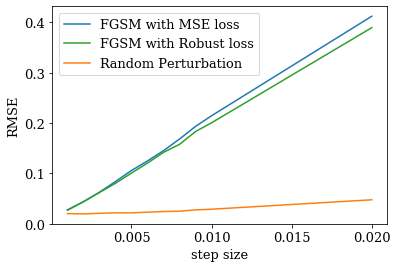

In [181]:
#plot rescale RMSE
#plot RMSE w.r.t step size (add more larger step: 0.1-1)
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':13})
#plt.plot(size, scale_rmse_pred_bad_pgd,label='PGD') 
plt.plot(size[:11], scale_rmse_pred_bad_fgsm[:11],label='FGSM with MSE loss')
plt.plot(size[:11], scale_rmse_pred_bad_fgsm_r[:11],label='FGSM with Robust loss',c='C2')
plt.plot(size[:11],scale_rmse_pred_bad_r[:11],label='Random Perturbation',c='C1')
#####horizontal line for normal MSE
#plt.plot(size[:11], [scale_mse_norm]*11, 'r--',label='Original') 
plt.xlabel('step size')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
plt.savefig('Rescaled_RMSE')

#plt.title('Root Mean Square Error for Different Step Sizes (Scaled)')

### Plot 2: variances and inverse-variance accuracy

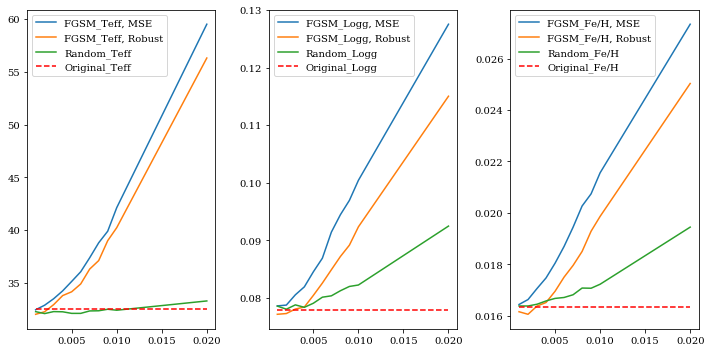

In [147]:
#plot std w.r.t step size: increases along step_size: full range
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':10})
f, (ax1, ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10,5))
#ax1.plot(size, np.array([x.compressed() for x in mean_var_bad_total_pgd])[:,0], label='PGD_Teff')
ax1.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_total_fgsm])[:,0][:11], label='FGSM_Teff, MSE')
ax1.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_total_fgsm_r])[:,0][:11], label='FGSM_Teff, Robust')
ax1.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_total_r])[:,0][:11], label='Random_Teff')
ax1.plot(size[:11], [mean_var[0]]*11, 'r--', label='Original_Teff') 
ax1.legend(loc='best')
#ax1.set_title('Total Variance of Teff')

#ax2.plot(size, np.array([x.compressed() for x in mean_var_bad_total_pgd])[:,1],label='PGD_Logg')
ax2.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_total_fgsm])[:,1][:11],label='FGSM_Logg, MSE')
ax2.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_total_fgsm_r])[:,1][:11],label='FGSM_Logg, Robust')
ax2.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_total_r])[:,1][:11],label='Random_Logg')
ax2.plot(size[:11], [mean_var[1]]*11, 'r--', label='Original_Logg') 
ax2.legend(loc='best')
#ax2.set_title('Total Variance of Logg')

#ax3.plot(size,  np.array([x.compressed() for x in mean_var_bad_total_pgd])[:,2],label='PGD_Fe/H')
ax3.plot(size[:11],  np.array([x.compressed() for x in mean_var_bad_total_fgsm])[:,2][:11],label='FGSM_Fe/H, MSE')
ax3.plot(size[:11],  np.array([x.compressed() for x in mean_var_bad_total_fgsm_r])[:,2][:11],label='FGSM_Fe/H, Robust')
ax3.plot(size[:11],  np.array([x.compressed() for x in mean_var_bad_total_r])[:,2][:11],label='Random_Fe/H')
ax3.plot(size[:11], [mean_var[2]]*11, 'r--', label='Original_Fe/H') 
ax3.legend(loc='best')
#ax3.set_title('Total Variance of Fe/H')

f.tight_layout()

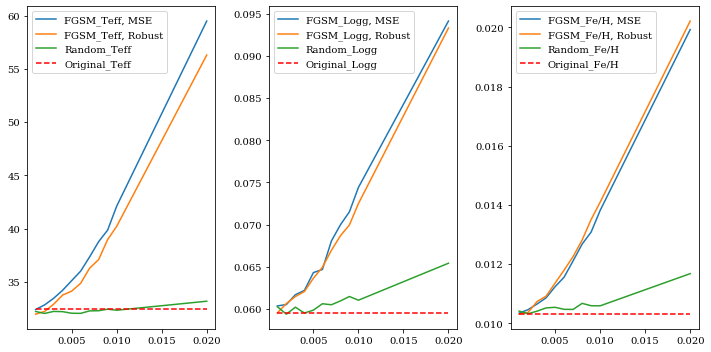

In [148]:
#plot std w.r.t step size: increases along step_size : full range
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':10})
f, (ax1, ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10,5))

#ax1.plot(size, np.array([x.compressed() for x in mean_var_bad_model_pgd])[:,0], label='PGD_Teff')
ax1.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_model_fgsm])[:,0][:11], label='FGSM_Teff, MSE')
ax1.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_model_fgsm_r])[:,0][:11], label='FGSM_Teff, Robust')
ax1.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_model_r])[:,0][:11], label='Random_Teff')
ax1.plot(size[:11], [mean_var_model[0]]*11, 'r--', label='Original_Teff') 
ax1.legend(loc='best')
#ax1.set_title('Model Variance of Teff')

#ax2.plot(size, np.array([x.compressed() for x in mean_var_bad_model_pgd])[:,1],label='PGD_Logg')
ax2.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_model_fgsm])[:,1][:11],label='FGSM_Logg, MSE')
ax2.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_model_fgsm_r])[:,1][:11],label='FGSM_Logg, Robust')
ax2.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_model_r])[:,1][:11],label='Random_Logg')
ax2.plot(size[:11], [mean_var_model[1]]*11, 'r--', label='Original_Logg') 
ax2.legend(loc='best')
#ax2.set_title('Model Variance of Logg')

#ax3.plot(size,  np.array([x.compressed() for x in mean_var_bad_model_pgd])[:,2],label='PGD_Fe/H')
ax3.plot(size[:11],  np.array([x.compressed() for x in mean_var_bad_model_fgsm])[:,2][:11],label='FGSM_Fe/H, MSE')
ax3.plot(size[:11],  np.array([x.compressed() for x in mean_var_bad_model_fgsm_r])[:,2][:11],label='FGSM_Fe/H, Robust')
ax3.plot(size[:11],  np.array([x.compressed() for x in mean_var_bad_model_r])[:,2][:11],label='Random_Fe/H')
ax3.plot(size[:11], [mean_var_model[2]]*11, 'r--', label='Original_Fe/H') 
ax3.legend(loc='best')
#ax3.set_title('Model Variance of Fe/H')

f.tight_layout()

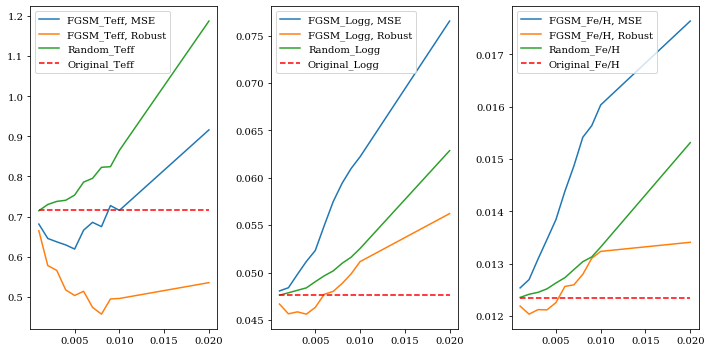

In [149]:
#plot std w.r.t step size: increases along step_size **predictive uncertainty
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':10})
f, (ax1, ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10,5))

#ax1.plot(size, np.array([x.compressed() for x in mean_var_bad_pred_pgd])[:,0], label='PGD_Teff')
ax1.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_pred_fgsm])[:,0][:11], label='FGSM_Teff, MSE')
ax1.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_pred_fgsm_r])[:,0][:11], label='FGSM_Teff, Robust')
ax1.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_pred_r])[:,0][:11], label='Random_Teff')
ax1.plot(size[:11], [mean_var_pred[0]]*11, 'r--', label='Original_Teff') 
ax1.legend(loc='best')
#ax1.set_title('Predictive Variance of Teff')

#ax2.plot(size, np.array([x.compressed() for x in mean_var_bad_pred_pgd])[:,1],label='PGD_Logg')
ax2.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_pred_fgsm])[:,1][:11],label='FGSM_Logg, MSE')
ax2.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_pred_fgsm_r])[:,1][:11],label='FGSM_Logg, Robust')
ax2.plot(size[:11], np.array([x.compressed() for x in mean_var_bad_pred_r])[:,1][:11],label='Random_Logg')
ax2.plot(size[:11], [mean_var_pred[1]]*11, 'r--', label='Original_Logg') 
ax2.legend(loc='best')
#ax2.set_title('Predictive Variance of Logg')

#ax3.plot(size,  np.array([x.compressed() for x in mean_var_bad_pred_pgd])[:,2],label='PGD_Fe/H')
ax3.plot(size[:11],  np.array([x.compressed() for x in mean_var_bad_pred_fgsm])[:,2][:11],label='FGSM_Fe/H, MSE')
ax3.plot(size[:11],  np.array([x.compressed() for x in mean_var_bad_pred_fgsm_r])[:,2][:11],label='FGSM_Fe/H, Robust')
ax3.plot(size[:11],  np.array([x.compressed() for x in mean_var_bad_pred_r])[:,2][:11],label='Random_Fe/H')
ax3.plot(size[:11], [mean_var_pred[2]]*11, 'r--', label='Original_Fe/H') 
ax3.legend(loc='best')
#ax3.set_title('Predictive Variance of Fe/H')

f.tight_layout()

In [150]:
#calculate inv = MSE/Predictive Variance for the adversarial attacks
def inverse_variance(y,pred_bad, mean_var_bad_pred):
    if type(mean_var_bad_pred) == np.ma.core.MaskedArray:
        VAR = mean_var_bad_pred
        MSE = np.sum((pred_bad[:,[0,1,19]]-y[:,[0,1,19]])**2)/y.shape[0]
        Inv_matrix = MSE/VAR
        
    else:
        Inv_matrix = np.zeros((len(pred_bad),3))
        for i in range(len(mean_var_bad_pred)):
            VAR = np.array([x.compressed() for x in mean_var_bad_pred])[i,:]
            for idx in [0,1,19]:
                MSE = np.sum((pred_bad[i][:,idx]-y[:,idx])**2)/y.shape[0]
                Inv_matrix[i,:] = MSE/VAR

    return Inv_matrix

In [151]:
#calculate inv for adv and random perturb & baseline
#inv_pgd = inverse_variance(y,adv_pred_pgd['pred_bad'], mean_var_bad_model_pgd)
inv_fgsm = inverse_variance(y_predi,adv_pred_fgsm['pred_bad'], mean_var_bad_model_fgsm)
inv_fgsm_r = inverse_variance(y_predi,adv_pred_fgsm_r['pred_bad'], mean_var_bad_model_fgsm_r)
inv_ran = inverse_variance(y_predi,adv_random['pred_bad'], mean_var_bad_model_r)  

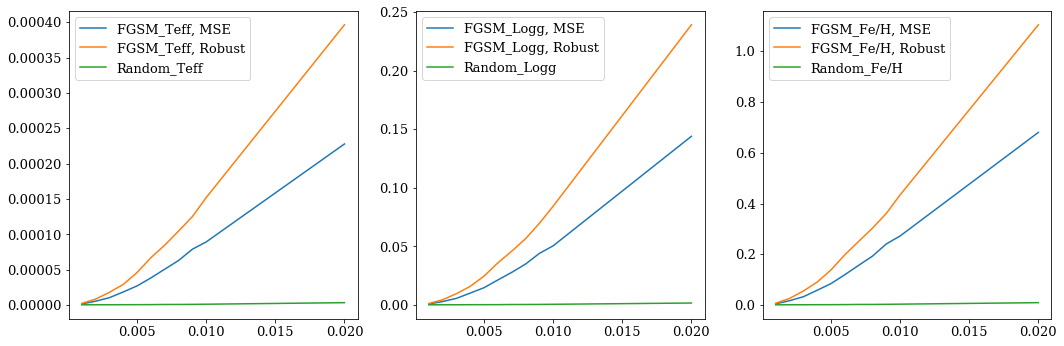

In [152]:
#plot INV w.r.t step size: to be contrast with random perturb: still being fooled!
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':13})
f, (ax1, ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,5))

#ax1.plot(size, inv_pgd[:,0], label='PGD_Teff')
ax1.plot(size[:11], inv_fgsm[:,0][:11], label='FGSM_Teff, MSE')
ax1.plot(size[:11], inv_fgsm_r[:,0][:11], label='FGSM_Teff, Robust')
ax1.plot(size[:11], inv_ran[:,0][:11], label='Random_Teff')
ax1.legend(loc='best')
#ax1.set_title('Inverse-variance Adversarial Accuracy of Teff')

#ax2.plot(size, inv_pgd[:,1],label='PGD_Logg')
ax2.plot(size[:11], inv_fgsm[:,1][:11],label='FGSM_Logg, MSE')
ax2.plot(size[:11], inv_fgsm_r[:,1][:11],label='FGSM_Logg, Robust')
ax2.plot(size[:11], inv_ran[:,1][:11],label='Random_Logg')
ax2.legend(loc='best')
#ax2.set_title('Inverse-variance Adversarial Accuracy of Logg')

#ax3.plot(size, inv_pgd[:,2],label='PGD_Fe/H')
ax3.plot(size[:11], inv_fgsm[:,2][:11],label='FGSM_Fe/H, MSE')
ax3.plot(size[:11], inv_fgsm_r[:,2][:11],label='FGSM_Fe/H, Robust')
ax3.plot(size[:11], inv_ran[:,2][:11],label='Random_Fe/H')
ax3.legend(loc='best')
#ax3.set_title('Inverse-variance Adversarial Accuracy of Fe/H')

f.tight_layout()

### plot 3: per example plot (star ID=244)

In [90]:
#load all true fluxes
import pickle
with open('rerun_1k_unscaled/true_flux_1557.pkl', 'rb') as f:
    true_flux = pickle.load(f)

In [91]:
true_fluxes = np.array(list(true_flux.values()))

In [153]:
#find nearest neighbors
from numpy import linalg as LA
def dist(label,flux, idx,k):
    dist_all = LA.norm((label - label[idx]), axis=1) 
    k_neigh = dist_all.argsort()[1:k+1] #get the closest k neighbours
    dist_label = LA.norm((label[k_neigh] - label[idx]), axis=1)
    dist_flux = LA.norm((flux[k_neigh] - flux[idx]), axis=1)  
    return k_neigh, dist_label, dist_flux

In [154]:
#generate neighbor points 
from astroNN.apogee import chips_pix_info, gap_delete, apogee_continuum, bitmask_boolean
from numpy import linalg as LA

def neighbor_delta_flux(true_fluxes, idx, k_idx, model='NN'):
    '''
    true_fluxes: physical model fluxes
    idx: the id of star of interest
    k_idx: the id of k neighbors of the label space
    model: NN/Linear/Cannon
    '''
    delta_flux = true_fluxes[k_idx] - true_fluxes[idx] 
    if model=='NN':
        Q = LA.norm(np.ones(7514)*0.01)        
        delta_flux = gap_delete(delta_flux, dr=14) #shape (10, 7514), true_flux has 8575 while NN needs 7514 as input
    else: #linear or Cannon, input already 8575
        Q = LA.norm(np.ones(8575)*0.01)
    delta_flux_n = delta_flux * Q / LA.norm(delta_flux,axis=1).reshape(-1,1)
    return delta_flux_n

In [171]:
idx = 244 
k_idx, dist_label, dist_flux = dist(scale_predictions(y[:,[0,1,19]]),true_fluxes,idx,10) #y[:,[0,1,19]]
delta_flux_neighbors = neighbor_delta_flux(true_fluxes,idx,k_idx, model='NN')

In [172]:
k_idx

array([ 61,  45, 318, 570, 964, 789, 626, 519, 571, 890])

In [173]:
import random
def neighbor_random_perturb(fluxes,idx, k=10):
    '''
    fluxes: data fluxes #for NN: len=7514, for Cannon/Linear: len = 8575
    idx: the id of star of interest
    k: number of random perturbation points
    model: NN/Linear/Cannon
    '''
    eps = 0.01
    result = []
    for i in range(k):
        random_sign = np.array([random.choice([-1, 1]) for i in fluxes[idx]])
        result.append(eps*random_sign)
    return np.array(result)

In [174]:
delta_flux_random = neighbor_random_perturb(x,idx, k=10)

In [175]:
delta_flux_random.shape

(10, 7514)

In [176]:
# per example predictions
y_predi_fgsm_p,y_predi_fgsm_eg_std_p  = final_model.test(x[idx]+delta_flux_neighbors)
y_predi_fgsm_r,y_predi_fgsm_eg_std_r  = final_model.test(x[idx]+delta_flux_random)

Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 0.74s elapsed
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 20 forward passes, 0.48s elapsed


In [177]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def plot_one_example(eps,y, y_predi, pred_bad, random_pred, attack_dict,plot_idxs,
                     points_random, points_neighbor, method='FGSM'):
    fig = plt.figure(figsize=(15, 10), dpi=100)
    plt.rc('font',**{'family': 'serif','weight':'medium', 'size':16})  
    ax = plt.gca()
    plt.scatter(y[plot_idxs,0],y[plot_idxs,1],marker= ",",s=120,rasterized=True,c='black',
                label='original') ##original should be the original y, not predictions?
    
    plt.scatter(y_predi[plot_idxs,0],y_predi[plot_idxs,1],marker= "D",s=120,rasterized=True,c='blue',
                label='original prediction') ##original should be the original y, not predictions?

    idx = [i for i, d in enumerate(attack_dict.keys()) if d==eps][0]
    print(idx)
    plt.scatter(pred_bad[idx][plot_idxs,0],pred_bad[idx][plot_idxs,1],marker="^",s=80,c='red' ,rasterized=True,
                label='FGSM attack')
    #plt.scatter(attack_eg[0],attack_eg[1],marker= "X",s=120,c='red',rasterized=True,label='FGSM Attack') #c = np.clip(attack_eg[19], -1.5, 0.25) throws out of range error
    
    #plot random perturb and k-neighbors
    plt.scatter(points_random[:,0], points_random[:,1], marker='.', s=120,c='green', rasterized=True,
                label='random perturbation')
    plt.scatter(points_neighbor[:,0], points_neighbor[:,1], marker='*', s=120,c='purple', rasterized=True,
                label='physical attack')
   #plt config
    plt.xlabel('$T_{eff}$', fontsize=30)
    plt.ylabel('$log{g}$', fontsize=30)
    #plt.title('Star_ID=359 Attack Results, step_size='+str(eps)+',method='+method, fontsize=30)
    plt.legend(loc='best', prop={'size':25})
    ax.invert_xaxis()
    ax.invert_yaxis()

    plt.tight_layout()

9


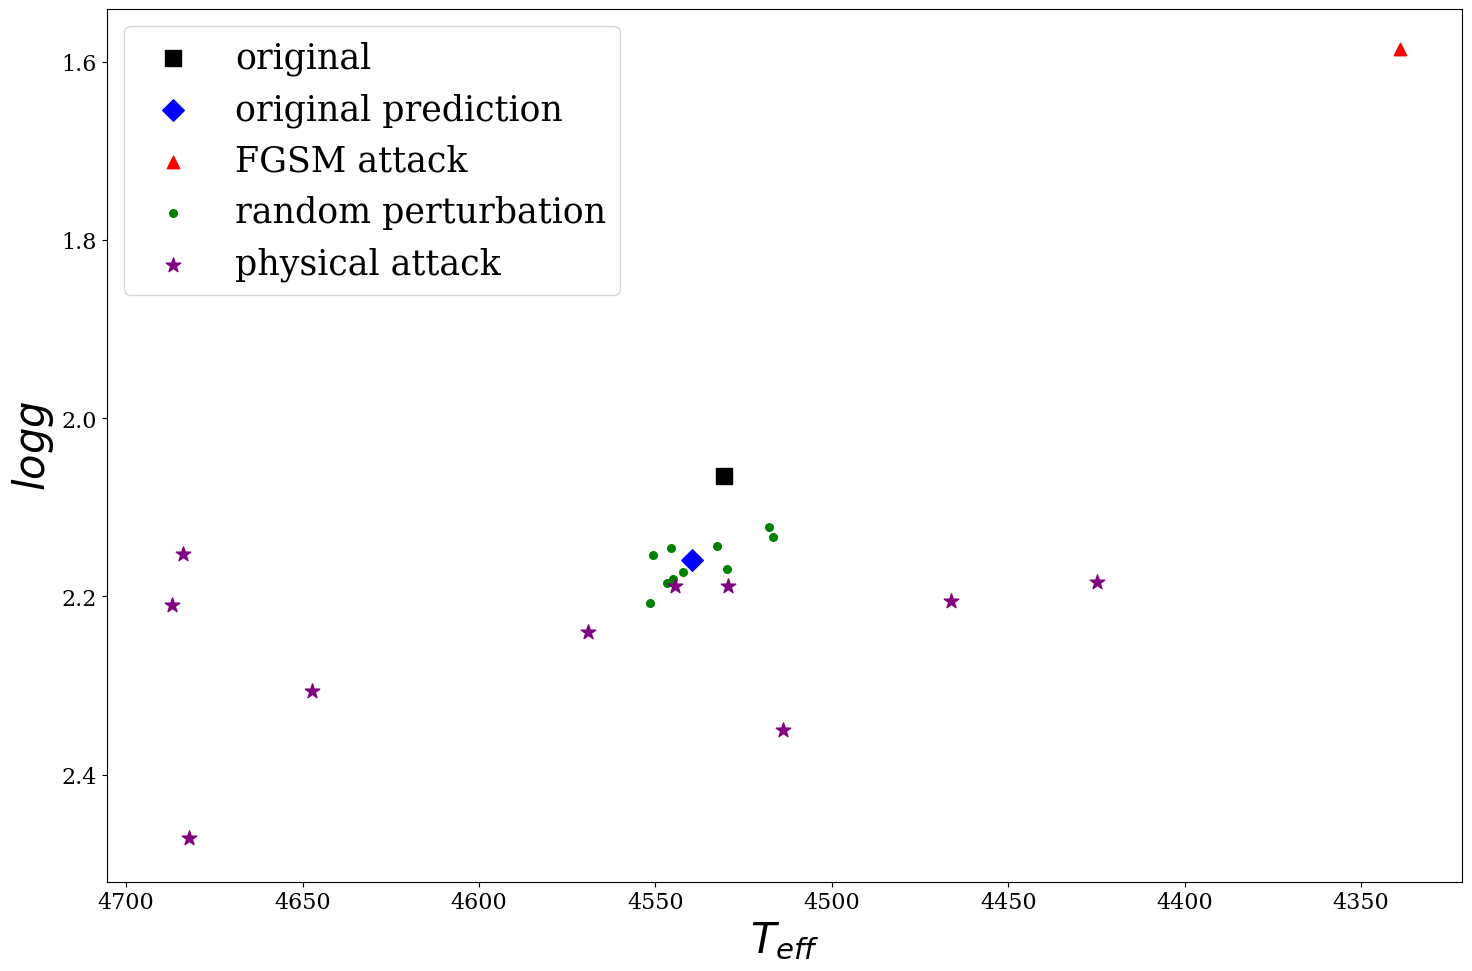

In [178]:
plot_idxs = [244] #one example only
plot_one_example(0.01,y,y_predi,adv_pred_fgsm['pred_bad'],  adv_random['pred_bad'], 
             fgsm_dict, plot_idxs,y_predi_fgsm_r,y_predi_fgsm_p,
             method='FGSM')

### Plot 5: 2d distribution of original, predicted and attacked labels

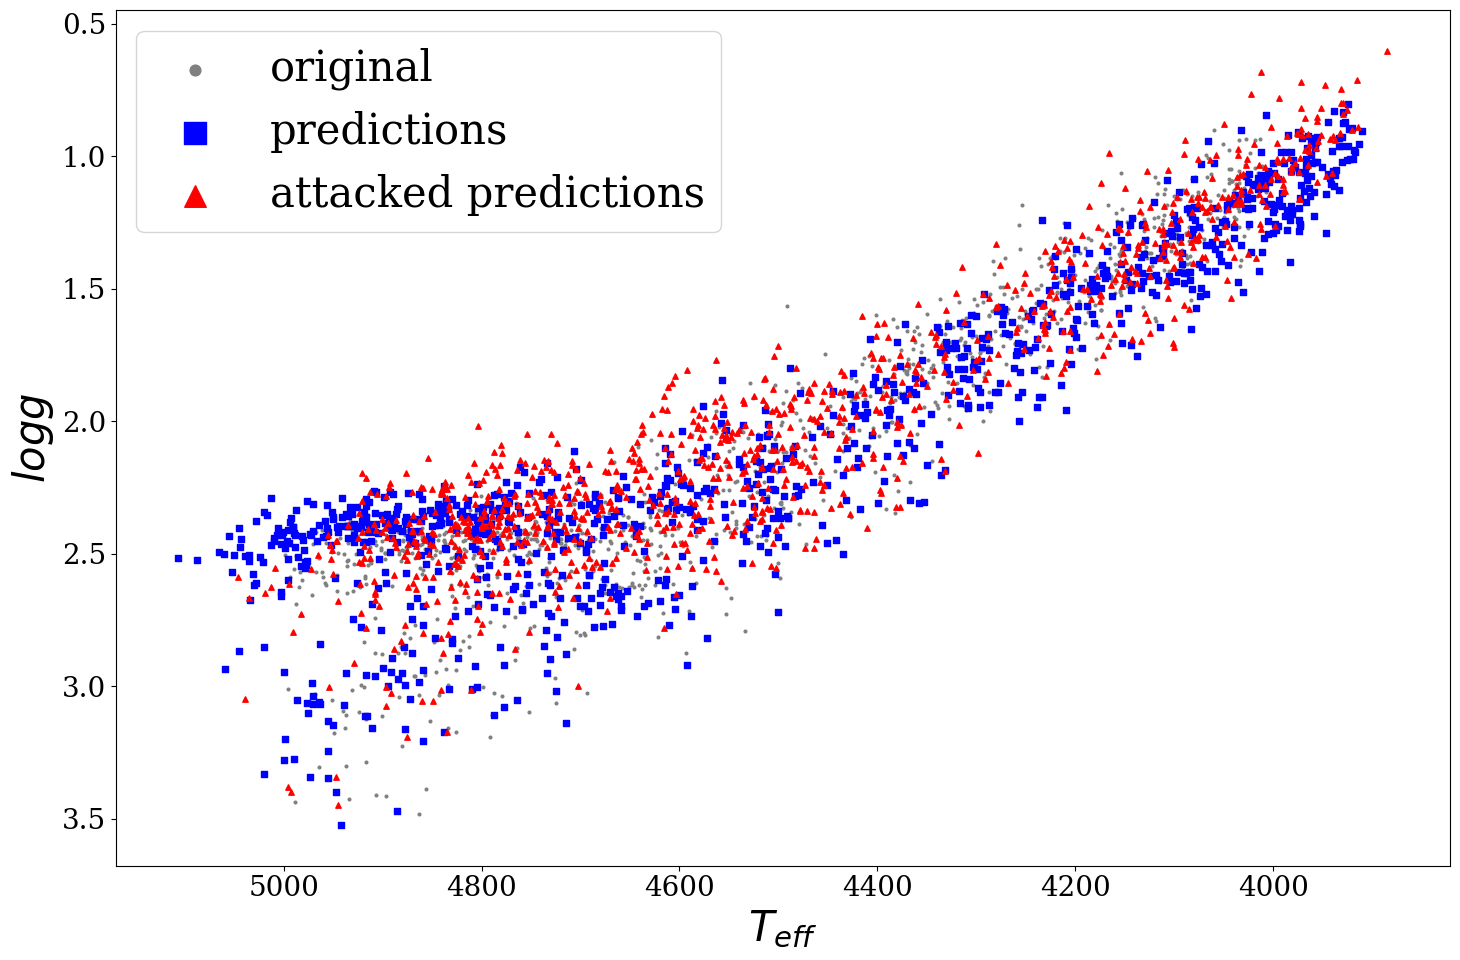

In [120]:
import matplotlib.pyplot as plt

eps='0.01'
fig = plt.figure(figsize=(15, 10), dpi=100)
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})
ax = plt.gca()
plt.scatter(y[:,0],y[:,1],marker= ".",s=15,c='grey', rasterized=True,
            label='original')
plt.scatter(y_predi[:,0],y_predi[:,1],marker=",",s=15,c='blue', rasterized=True,
            label='predictions')
plt.scatter(adv_pred_fgsm_r['pred_bad'][9][:,0],adv_pred_fgsm_r['pred_bad'][9][:,1],marker="^",s=15,c='red', rasterized=True,
            label='attacked predictions')
plt.xlabel('$T_{eff}$', fontsize=30)
plt.ylabel('$log{g}$', fontsize=30)
#plt.title('Cannon Attack: Label Distribution, step_size='+str(eps), fontsize=30)
plt.legend(markerscale=4,loc='best', prop={'size':30})
ax.invert_xaxis()
ax.invert_yaxis()

plt.tight_layout()
#plt.show()

### Plot 6: banner plots for fluxes

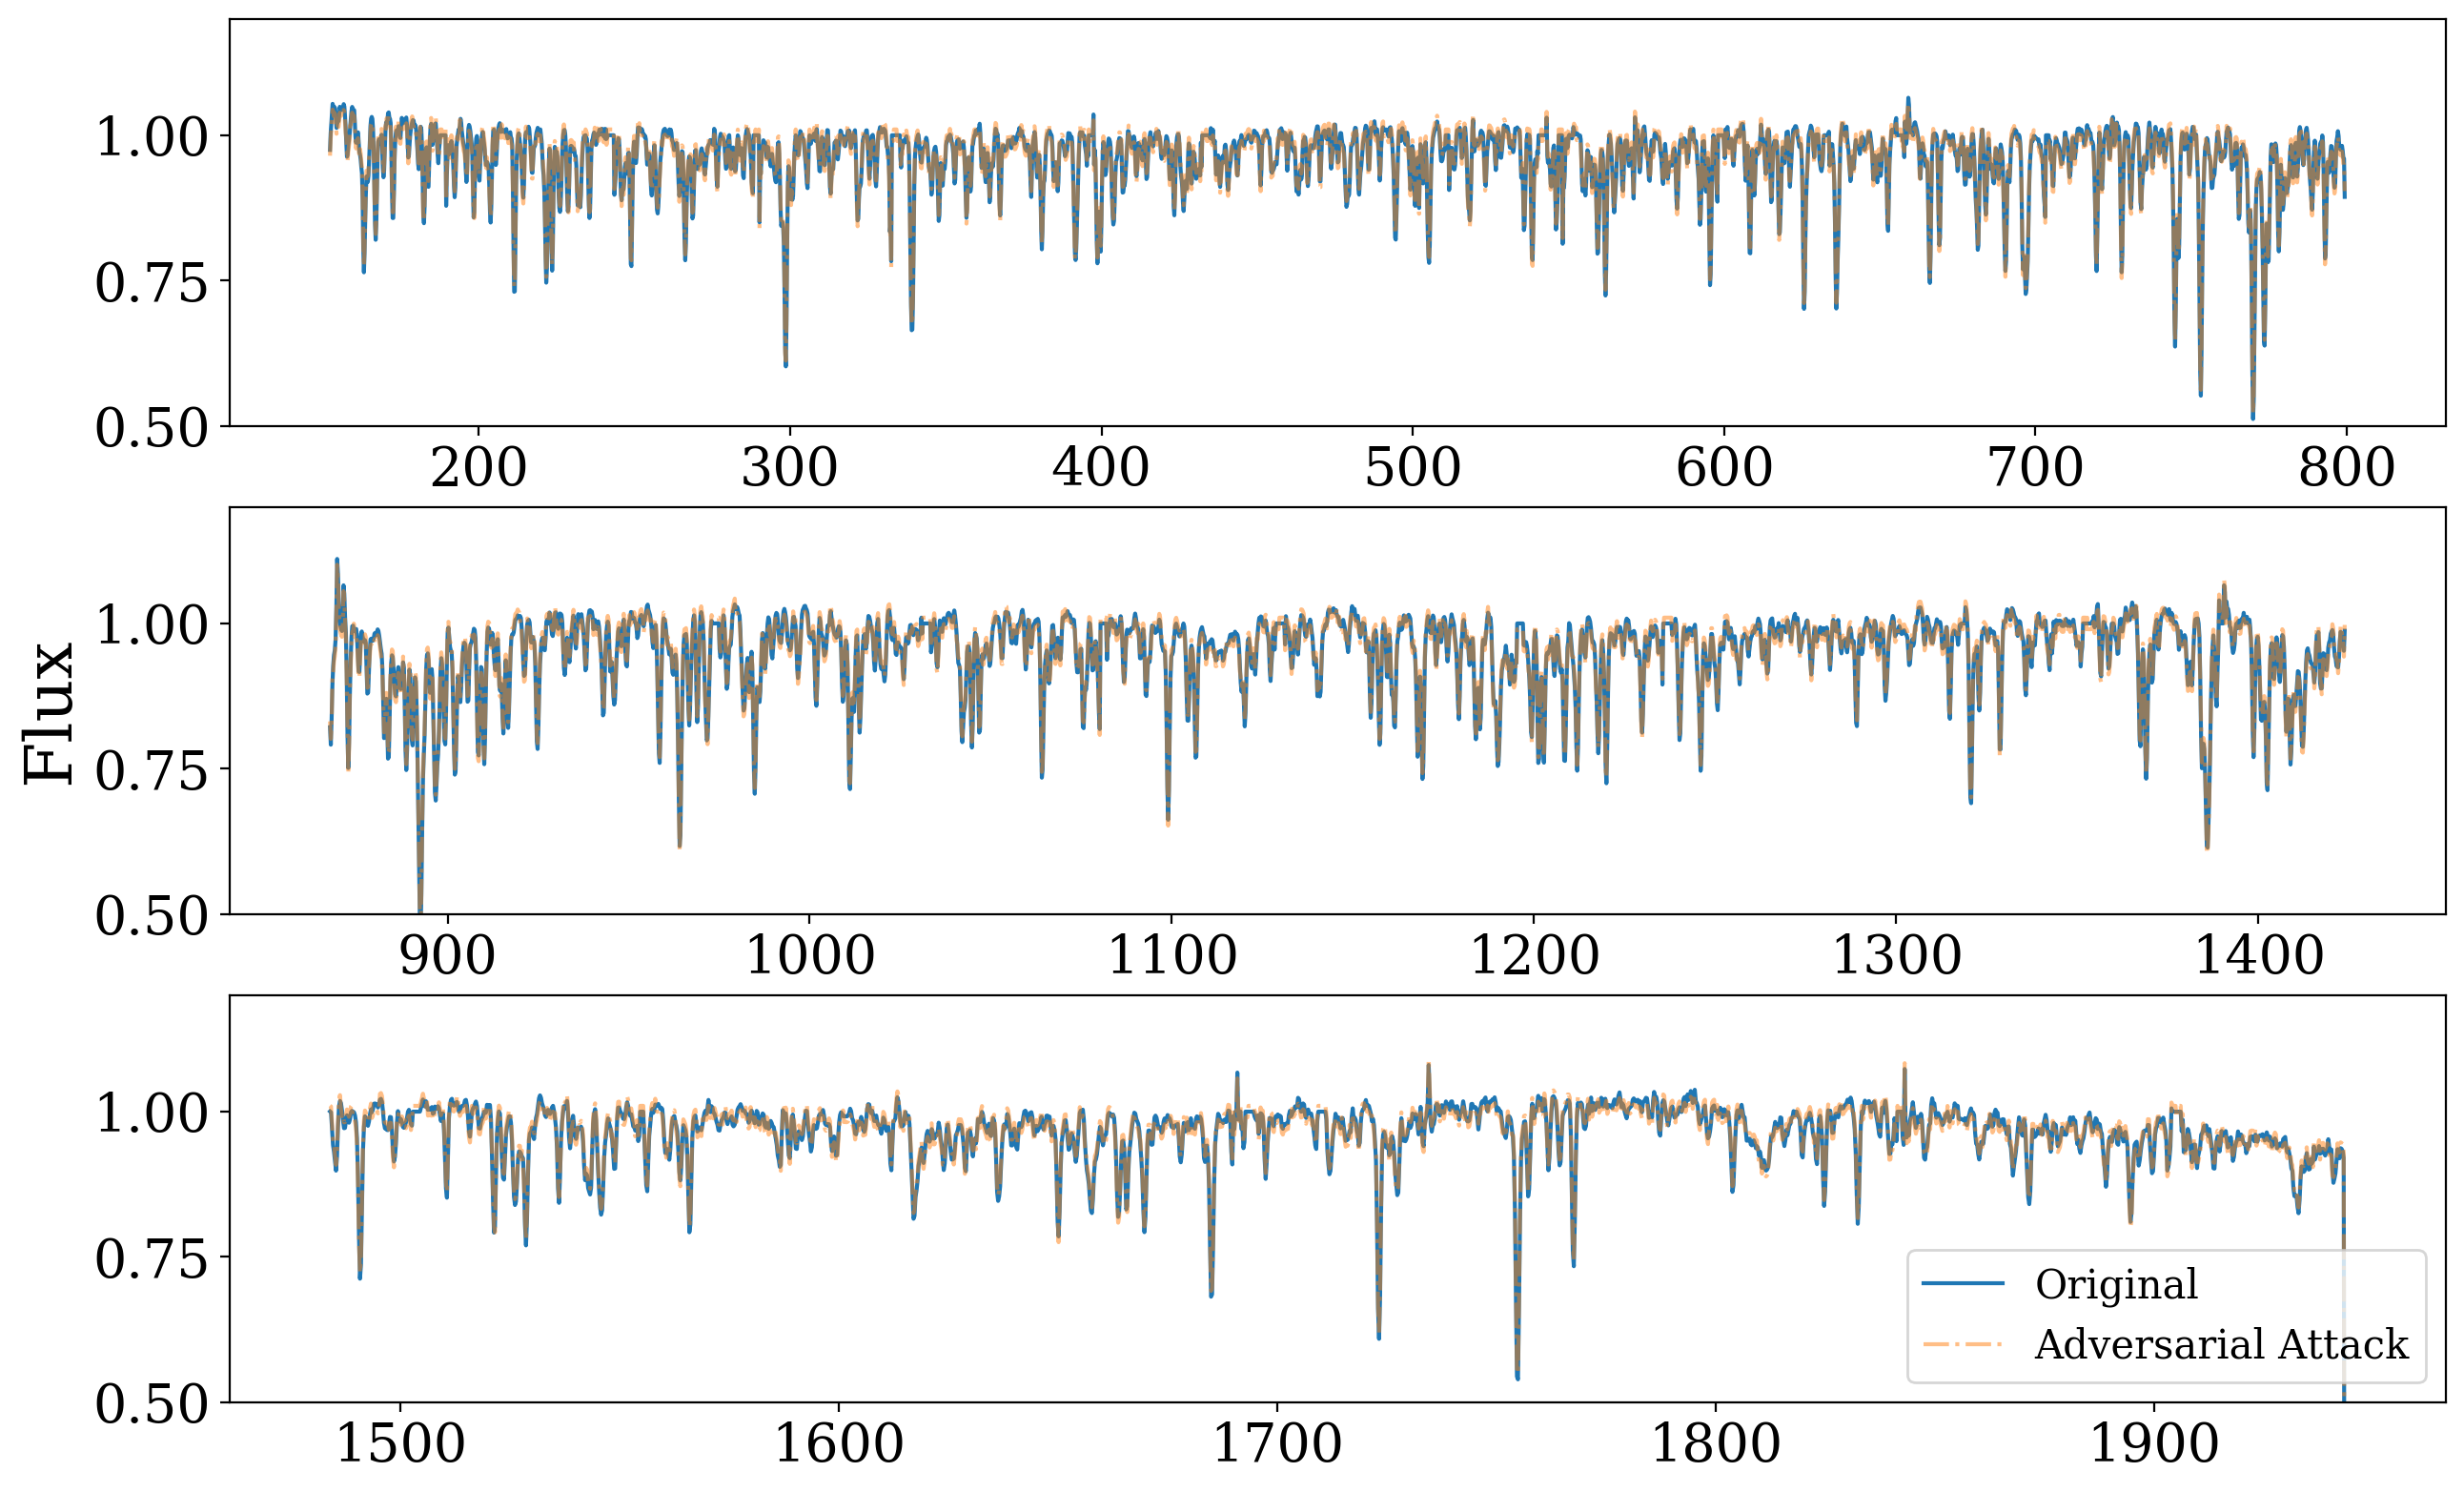

In [121]:
from astroNN.apogee.chips import wavelength_solution, chips_split
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})
lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000
worst_idx = 244

fig = plt.figure(figsize=(15, 13), dpi=200)
blue, green, red = chips_split(x[worst_idx], dr=14) 
blue, green, red = blue[0], green[0], red[0]
blue_bad, green_bad, red_bad = chips_split(fgsm_dict_r.get(0.01)[worst_idx], dr=14) #universal
#blue_bad, green_bad, red_bad = chips_split(attack_eg['fgsm_0.01'][np.where(plot_idxs_fgsm==359)[0][0]], dr=14)  #per_example
blue_bad, green_bad, red_bad= blue_bad[0], green_bad[0], red_bad[0]

#fig.suptitle('APOGEE Spectra Example (ID='+str(worst_idx)+')' , fontsize=25)
ax1 = fig.add_subplot(411)
ax1.plot(lambda_blue, blue, linewidth=1.5,rasterized=True, label='Original')
ax1.plot(lambda_blue, blue_bad,'-.', linewidth=1.5,rasterized=True, label='Adversarial Attack', alpha=0.5 )
ax1.set_ylim((0.5, 1.2))
ax2 = fig.add_subplot(412)
ax2.set_ylabel('Flux', fontsize=25)
ax2.plot(lambda_green, green, linewidth=1.5,rasterized=True, label='Original')
ax2.plot(lambda_green, green_bad, '-.',linewidth=1.5,rasterized=True, label='Adversarial Attack', alpha=0.5)
ax2.set_ylim((0.5, 1.2))
ax3 = fig.add_subplot(413)
ax3.plot(lambda_red, red, linewidth=1.5,rasterized=True, label='Original')
ax3.plot(lambda_red, red_bad,'-.', linewidth=1.5,rasterized=True, label='Adversarial Attack', alpha=0.5)
ax3.set_ylim((0.5, 1.2))
ax3.legend(loc='lower right',prop={'size': 15})

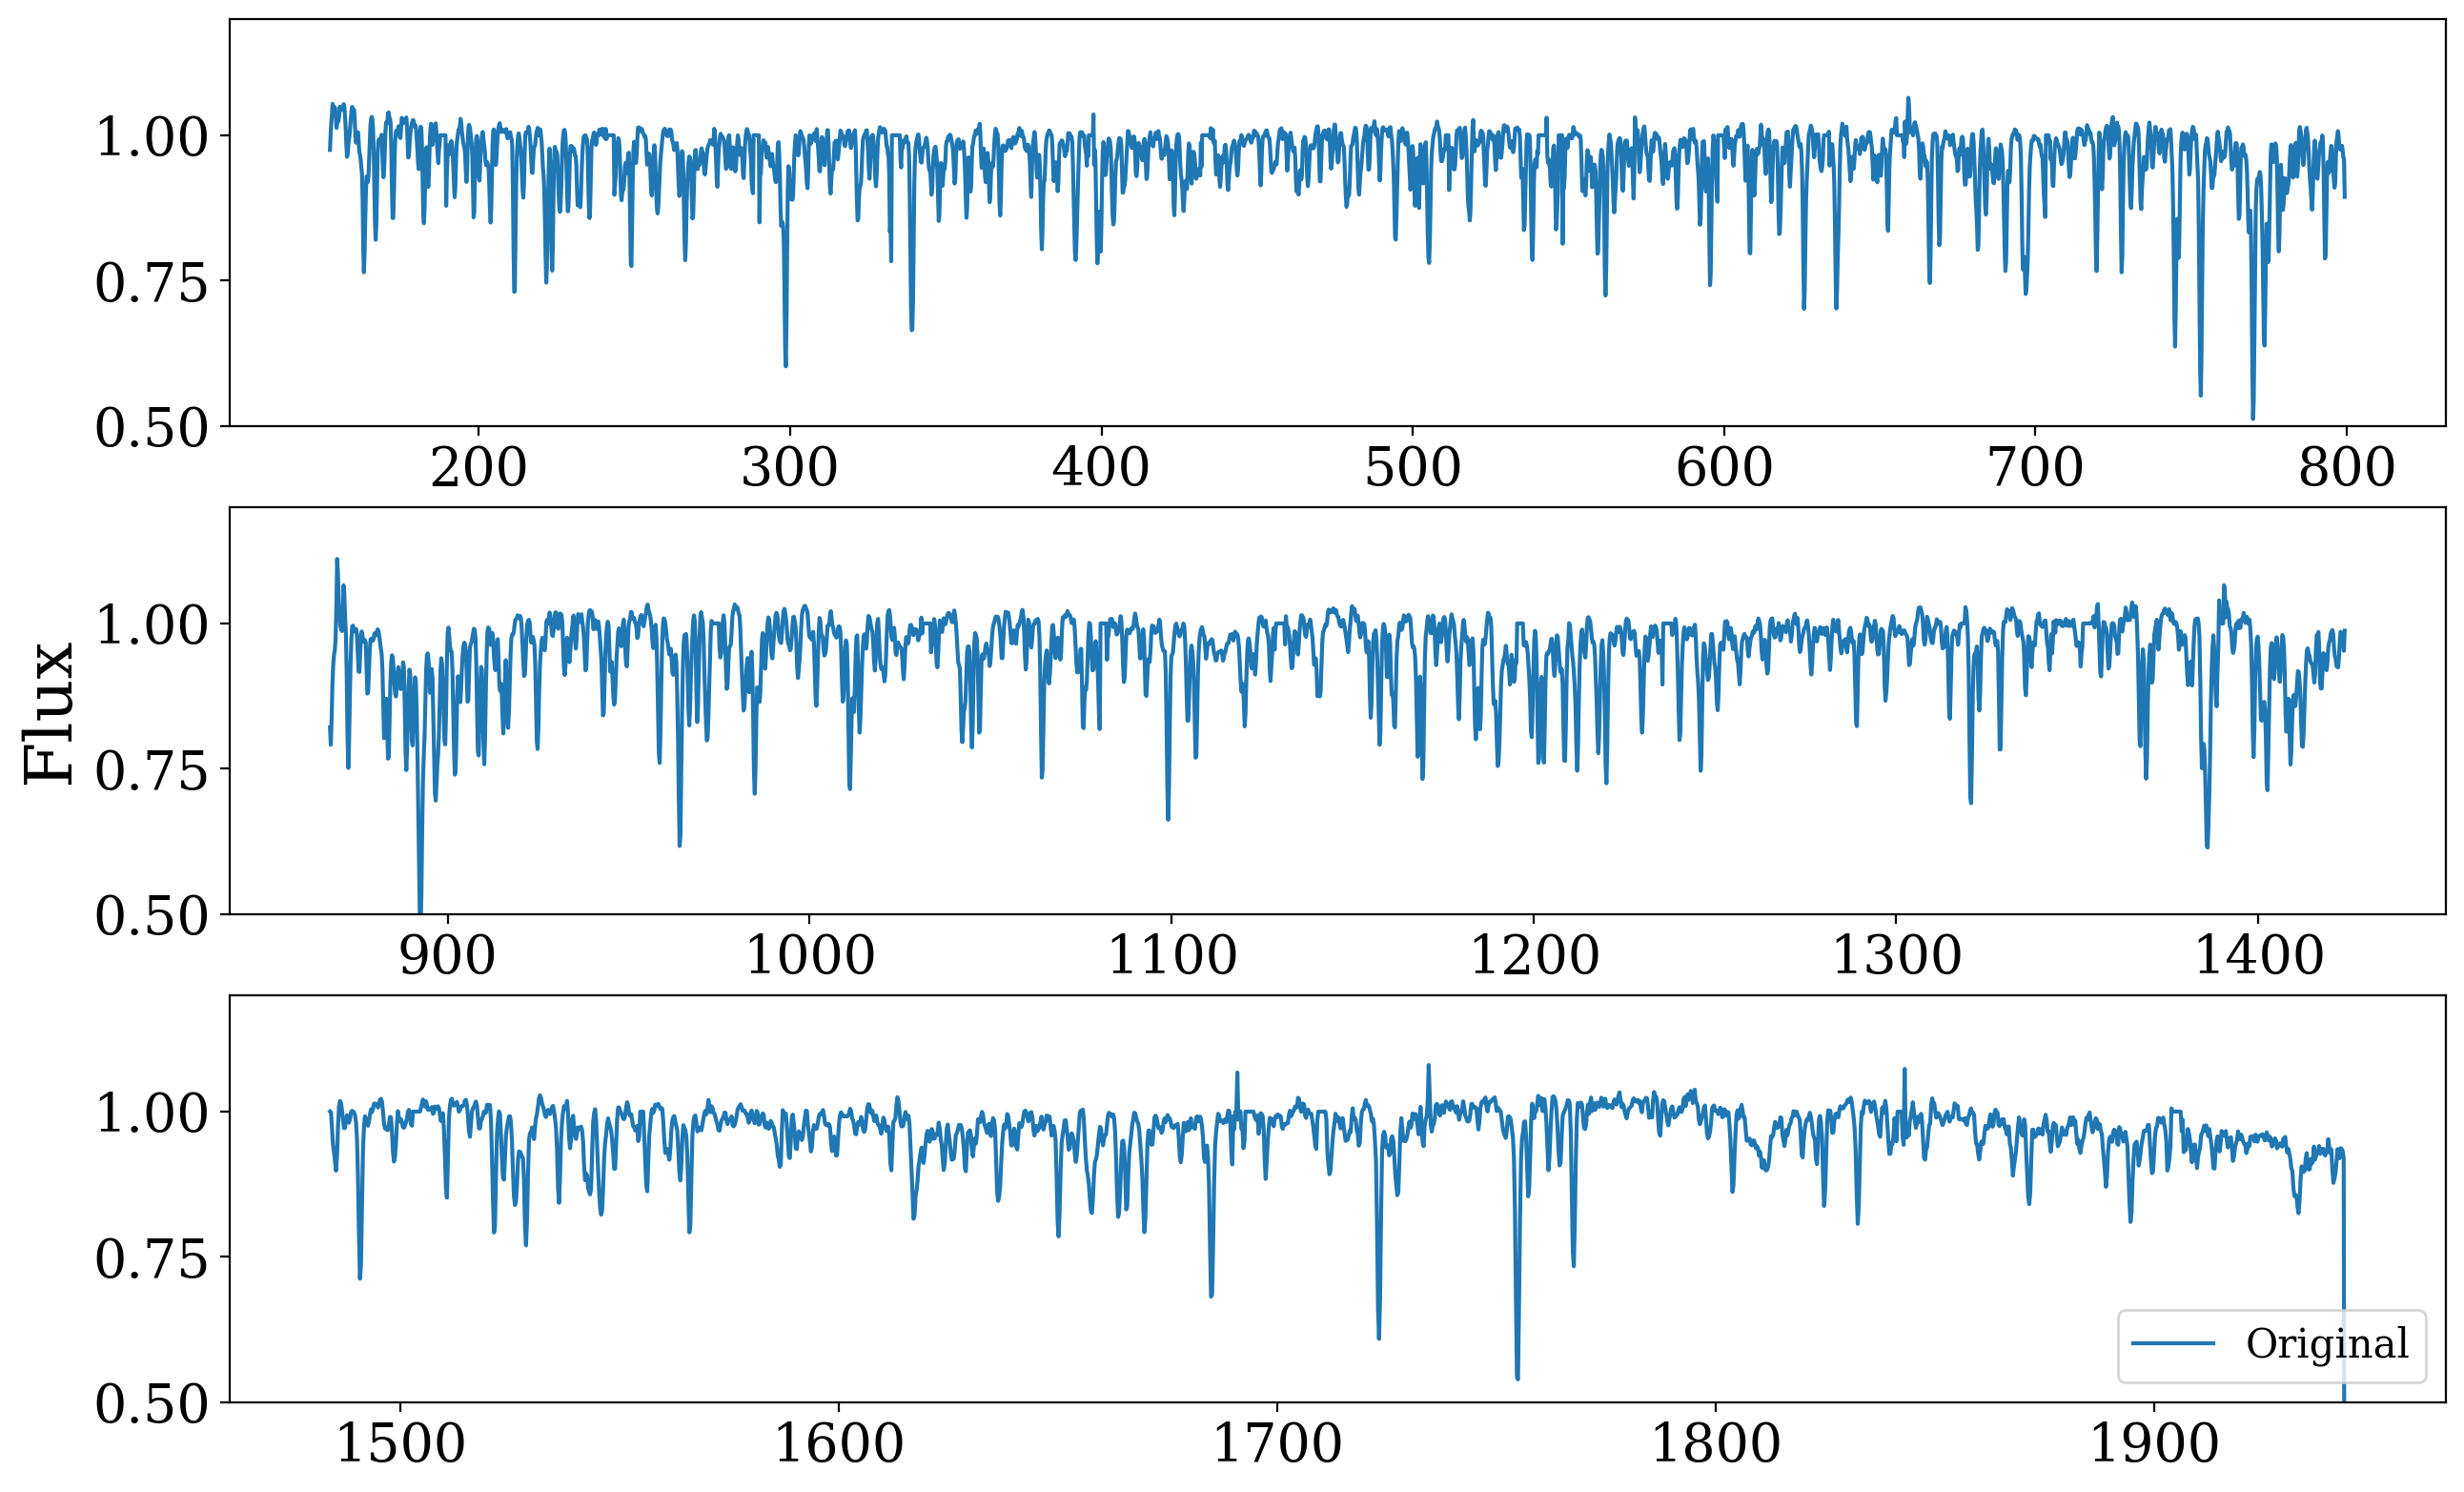

In [314]:
from astroNN.apogee.chips import wavelength_solution, chips_split
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})
lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000
worst_idx = 244
fig = plt.figure(figsize=(15, 13), dpi=200)
blue, green, red = chips_split(x[worst_idx], dr=14) 
blue, green, red = blue[0], green[0], red[0]
blue_bad, green_bad, red_bad = chips_split(x[worst_idx], dr=14) 
blue_bad, green_bad, red_bad= blue_bad[0], green_bad[0], red_bad[0]

# fig.suptitle('APOGEE Spectra Example (ID='+str(worst_idx)+')' , fontsize=25)
ax1 = fig.add_subplot(411)
ax1.plot(lambda_blue, blue, linewidth=1.5,rasterized=True, label='Original')
#ax1.plot(lambda_blue, blue_bad,'-.', linewidth=1.5,rasterized=True, label='Adversarial Attack', alpha=0.5 )
ax1.set_ylim((0.5, 1.2))
ax2 = fig.add_subplot(412)
ax2.set_ylabel('Flux', fontsize=25)
ax2.plot(lambda_green, green, linewidth=1.5,rasterized=True, label='Original')
#ax2.plot(lambda_green, green_bad, '-.',linewidth=1.5,rasterized=True, label='Adversarial Attack', alpha=0.5)
ax2.set_ylim((0.5, 1.2))
ax3 = fig.add_subplot(413)
ax3.plot(lambda_red, red, linewidth=1.5,rasterized=True, label='Original')
#ax3.plot(lambda_red, red_bad,'-.', linewidth=1.5,rasterized=True, label='Adversarial Attack', alpha=0.5)
ax3.set_ylim((0.5, 1.2))
ax3.legend(loc='lower right',prop={'size': 15})

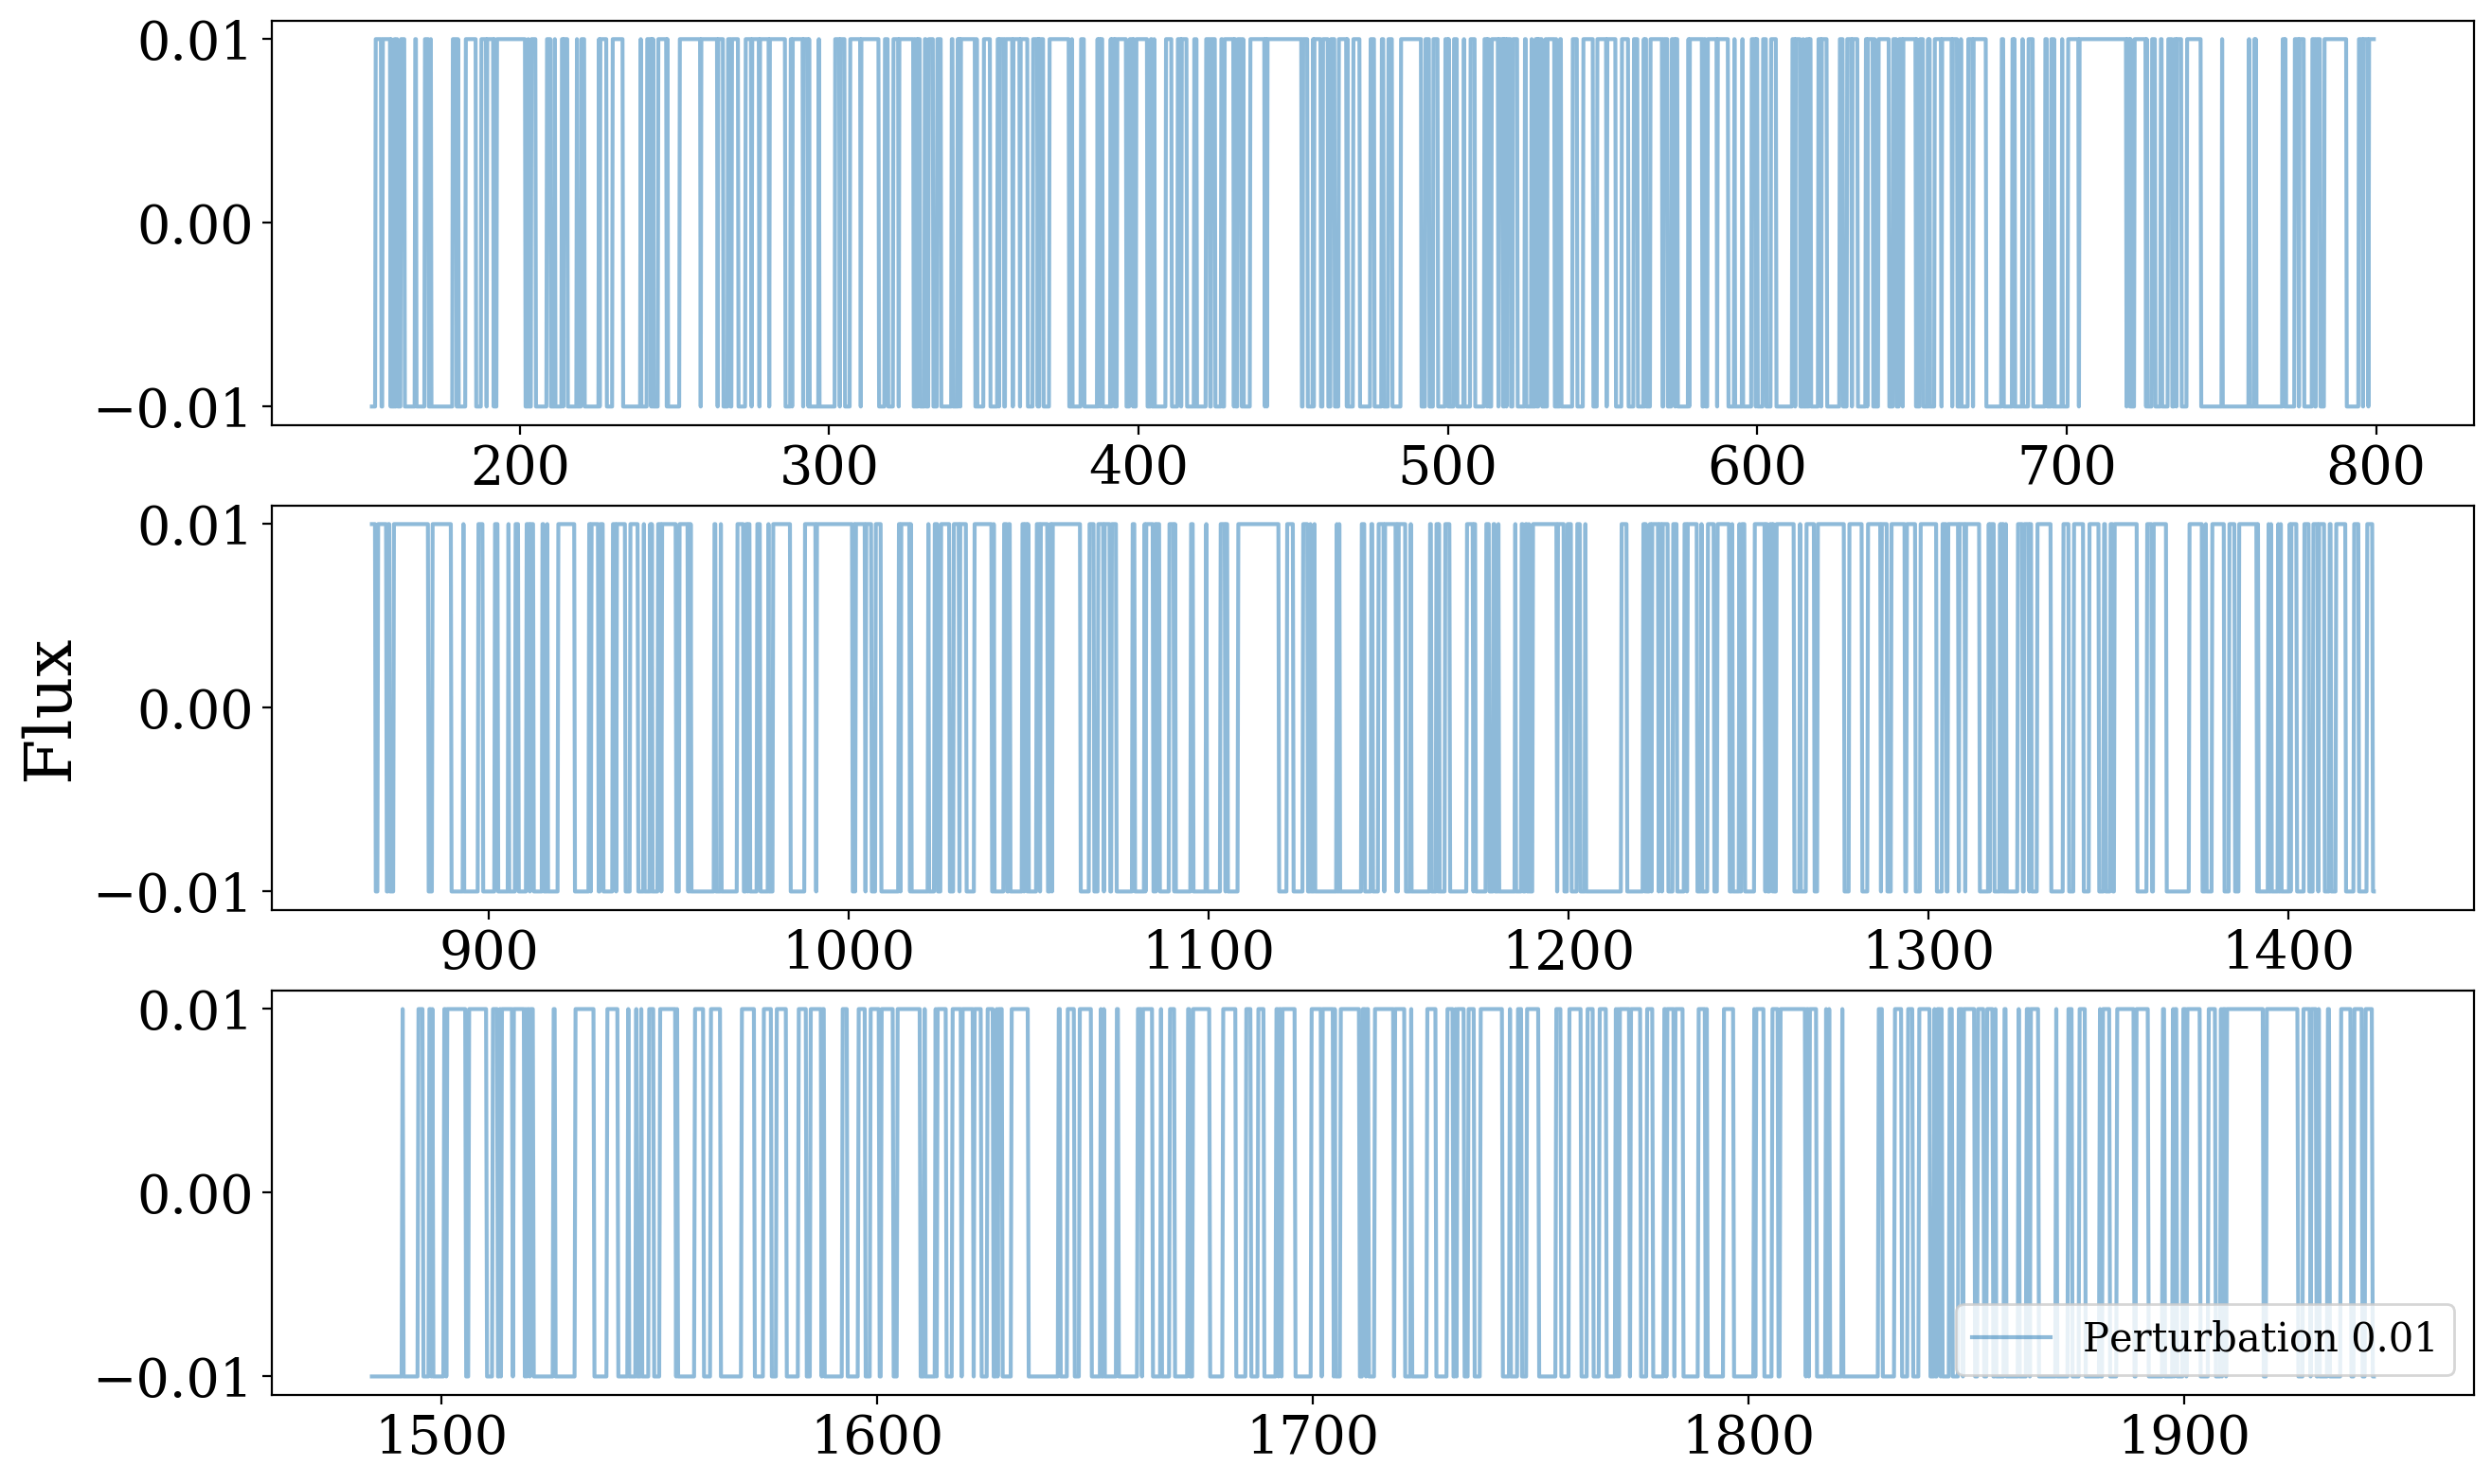

In [319]:
#plot the perturbation
from astroNN.apogee.chips import wavelength_solution, chips_split
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})
lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000
worst_idx = 244


fig = plt.figure(figsize=(15, 13), dpi=200)
blue, green, red = chips_split(fgsm_dict_r.get(0.01)[worst_idx] - x[worst_idx], dr=14)  #diff: perturb
blue, green, red = blue[0], green[0], red[0]


#fig.suptitle('APOGEE Spectra Example (ID='+str(worst_idx)+')' , fontsize=25)
ax1 = fig.add_subplot(411)
ax1.plot(lambda_blue, blue, linewidth=1.5,rasterized=True, label='Perturbation 0.01',alpha=0.5)
#ax1.set_ylim((0.5, 1.2))
ax2 = fig.add_subplot(412)
ax2.set_ylabel('Flux', fontsize=25)
ax2.plot(lambda_green, green, linewidth=1.5,rasterized=True, label='Perturbation 0.01',alpha=0.5)
#ax2.set_ylim((0.5, 1.2))
ax3 = fig.add_subplot(413)
ax3.plot(lambda_red, red, linewidth=1.5,rasterized=True, label='Perturbation 0.01',alpha=0.5)
#ax3.set_ylim((0.5, 1.2))
ax3.legend(loc='lower right',prop={'size': 15})